# Классификация на дереве


**ЗАДАНИЕ 5**

Необходимо произвести предобработку данных, обучить решающие деревья с различными параметрами, оценить модели с помощью рассмотренных метрик, объяснить выбор определенной метрики и аргументировать выбор настроек алгоритма (подбор гиперпараметров).

## Импортируем необходимые библиотеки

In [1]:
import numpy as np
import pandas as pd
import scipy.stats
import warnings
warnings.filterwarnings("ignore")

## Импортируем dataset

In [294]:
url = 'https://drive.google.com/file/d/1vBOV5sYTeAkAtAm31sX3hDOyb2eDN9A8/view?usp=sharing'
url='https://drive.google.com/uc?id=' + url.split('/')[-2]
df = pd.read_csv(url)
df.head() 

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


**Features:**

- `PassengerId`  - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.

- `HomePlanet` - The planet the passenger departed from, typically their planet of permanent residence.

- `CryoSleep` - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.

- `Cabin` - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
Destination - The planet the passenger will be debarking to.

- `Age` - The age of the passenger.

- `VIP` - Whether the passenger has paid for special VIP service during the voyage.
- `RoomService`, `FoodCourt`, `ShoppingMall`, `Spa`, `VRDeck` - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.

- `Name` - The first and last names of the passenger.

- `Transported` - Whether the passenger was transported to another dimension. `This is the target, the column you are trying to predict.`

Посмотрим типы двнных

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


Оценим пропуски

In [295]:
df.isna().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

In [298]:
df[df.RoomService.isna()]

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
25,0020_05,Earth,True,E/0/S,PSO J318.5-22,1.0,False,NaN,0.0,0.0,0.0,0.0,Mael Brantuarez,False
35,0031_03,Mars,False,F/9/P,TRAPPIST-1e,20.0,False,NaN,0.0,1750.0,990.0,0.0,Dontch Datie,True
83,0091_01,Earth,True,G/16/S,TRAPPIST-1e,26.0,False,NaN,0.0,0.0,0.0,0.0,Deanne Yorkland,True
132,0141_01,Mars,False,F/30/P,TRAPPIST-1e,31.0,False,NaN,0.0,97.0,0.0,0.0,Pyrohs Harte,False
170,0193_02,Mars,False,F/41/P,TRAPPIST-1e,23.0,False,NaN,0.0,8.0,1072.0,0.0,Frook Raf,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8425,8998_02,Earth,False,E/591/S,TRAPPIST-1e,47.0,False,NaN,1.0,0.0,967.0,5.0,Jonaye Englence,False
8450,9026_01,Earth,True,G/1463/P,TRAPPIST-1e,58.0,False,NaN,0.0,0.0,0.0,0.0,Mathy Boyers,True
8525,9101_01,Earth,False,F/1865/P,TRAPPIST-1e,21.0,False,NaN,0.0,496.0,430.0,0.0,Gera Frazie,False
8534,9112_01,Mars,False,D/290/P,TRAPPIST-1e,28.0,False,NaN,0.0,0.0,0.0,0.0,Wealke Brin,False


In [5]:
df.select_dtypes(include=['float64']).dtypes

Age             float64
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
dtype: object

In [6]:
df.select_dtypes(include=['object']).dtypes

PassengerId    object
HomePlanet     object
CryoSleep      object
Cabin          object
Destination    object
VIP            object
Name           object
dtype: object

In [192]:
# Числовые данные
num_cols = list(df.select_dtypes(include=['float64']).dtypes.index)

# категориальные данные
cat_cols = list(df.select_dtypes(include=['object']).dtypes.index)
cat_cols.remove('PassengerId')

# 
other = ['PassengerId']

# целевые данные
target_col = ['Transported']  # Выживание


# новый порядок
cols = other +  num_cols + cat_cols + target_col

ПОДКРАСКА DF - https://kanoki.org/2019/01/02/pandas-trick-for-the-day-color-code-columns-rows-cells-of-dataframe/

In [193]:
def coloring(val):

    if type(val) == type('0'):
      color = 'green'
    elif type(val) == np.float: color = 'blue'
    #elif val is np.NaN: color = 'red'
    else: color = 'white'
    return 'color: %s' % color

# Перераспределим колонки в новый датасет для работы
data = df[cols]


data.head(20).style.applymap(coloring).highlight_null(null_color='yellow')


,PassengerId,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,HomePlanet,CryoSleep,Cabin,Destination,VIP,Name,Transported
0,0001_01,39.000000,0.000000,0.000000,0.000000,0.000000,0.000000,Europa,False,B/0/P,TRAPPIST-1e,False,Maham Ofracculy,False
1,0002_01,24.000000,109.000000,9.000000,25.000000,549.000000,44.000000,Earth,False,F/0/S,TRAPPIST-1e,False,Juanna Vines,True
2,0003_01,58.000000,43.000000,3576.000000,0.000000,6715.000000,49.000000,Europa,False,A/0/S,TRAPPIST-1e,True,Altark Susent,False
3,0003_02,33.000000,0.000000,1283.000000,371.000000,3329.000000,193.000000,Europa,False,A/0/S,TRAPPIST-1e,False,Solam Susent,False
4,0004_01,16.000000,303.000000,70.000000,151.000000,565.000000,2.000000,Earth,False,F/1/S,TRAPPIST-1e,False,Willy Santantines,True
5,0005_01,44.000000,0.000000,483.000000,0.000000,291.000000,0.000000,Earth,False,F/0/P,PSO J318.5-22,False,Sandie Hinetthews,True
6,0006_01,26.000000,42.000000,1539.000000,3.000000,0.000000,0.000000,Earth,False,F/2/S,TRAPPIST-1e,False,Billex Jacostaffey,True
7,0006_02,28.000000,0.000000,0.000000,0.000000,0.000000,nan,Earth,True,G/0/S,TRAPPIST-1e,False,Candra Jacostaffey,True
8,0007_01,35.000000,0.000000,785.000000,17.000000,216.000000,0.000000,Earth,False,F/3/S,TRAPPIST-1e,False,Andona Beston,True
9,0008_01,14.000000,0.000000,0.000000,0.000000,0.000000,0.000000,Europa,True,B/1/P,55 Cancri e,False,Erraiam Flatic,True


# Посмотрим распределение в данных
***

работа с `sns`:
- https://nagornyy.me/it/vizualizatsiia-dannykh-v-seaborn/
- https://towardsdatascience.com/10-must-know-seaborn-functions-for-multivariate-data-analysis-in-python-7ba94847b117

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

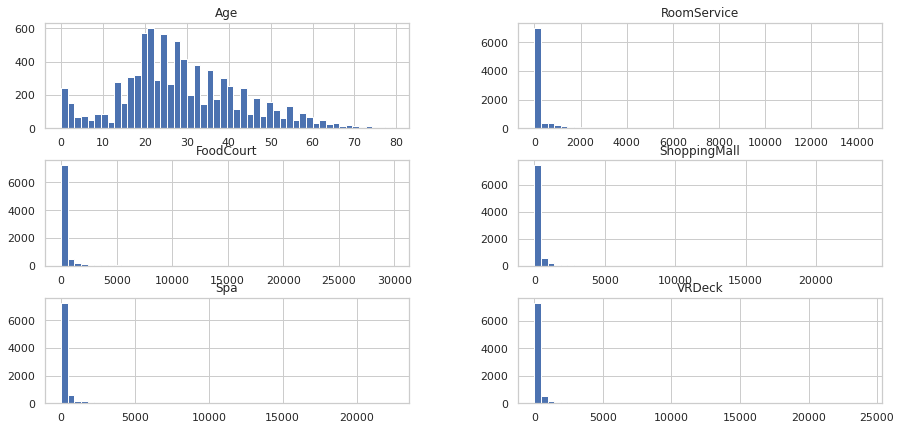

In [87]:
num_attributes = data.select_dtypes(include=['float64'])
num_attributes.hist(bins=50,figsize=(15,7));

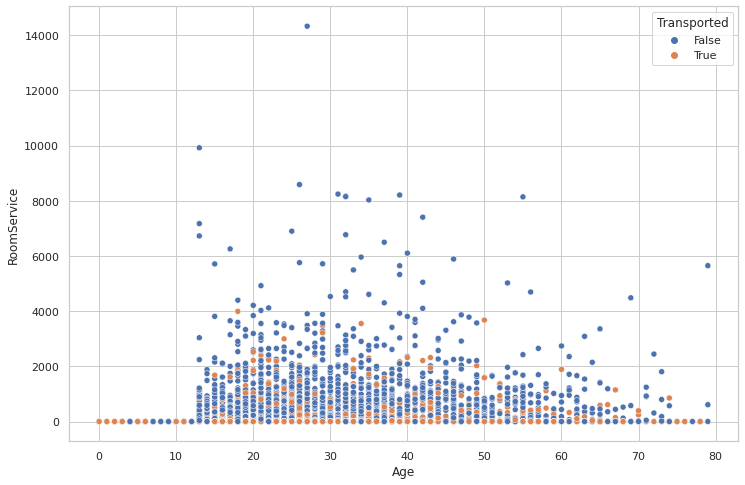

In [11]:
sns.set(style="whitegrid", rc={'figure.figsize':(12, 8)})
sns.scatterplot(x="Age", y="RoomService",  data=data, hue='Transported');

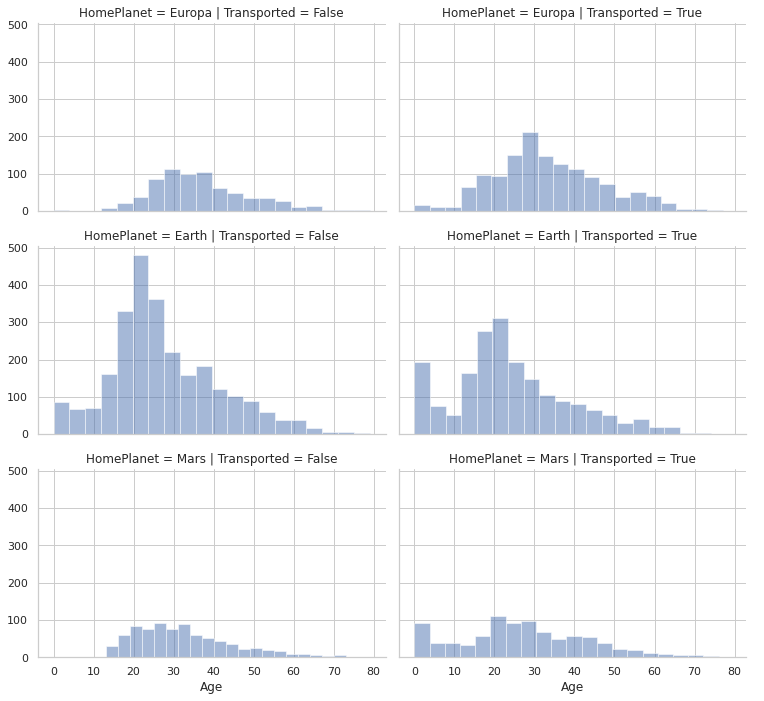

In [12]:
grid = sns.FacetGrid(data, col='Transported', row='HomePlanet', height = 3.3, aspect=1.6)
grid.map(plt.hist, 'Age', alpha=.5, bins=20)
grid.add_legend();

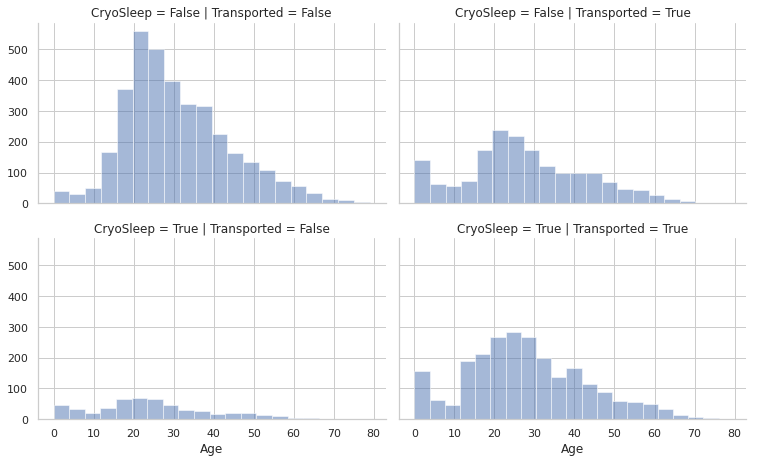

In [120]:
grid = sns.FacetGrid(data, col='Transported', row='CryoSleep', height = 3.3, aspect=1.6)
grid.map(plt.hist, 'Age', alpha=.5, bins=20)
grid.add_legend();

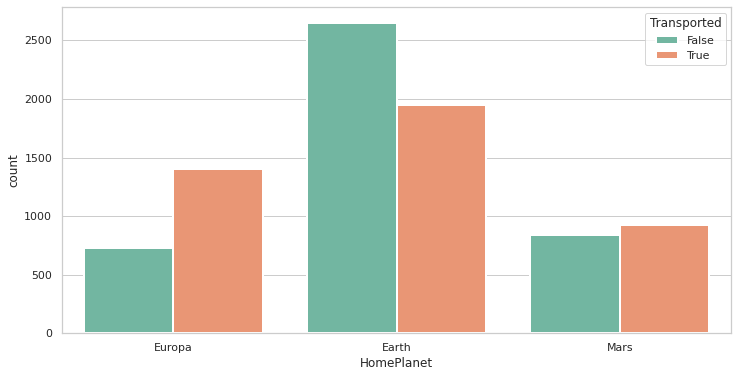

In [13]:
plt.subplots(figsize = (12,6))
ax = sns.countplot(x = "HomePlanet", 
                   hue="Transported",
                   data = data,
                   palette='Set2',
                   linewidth=2)


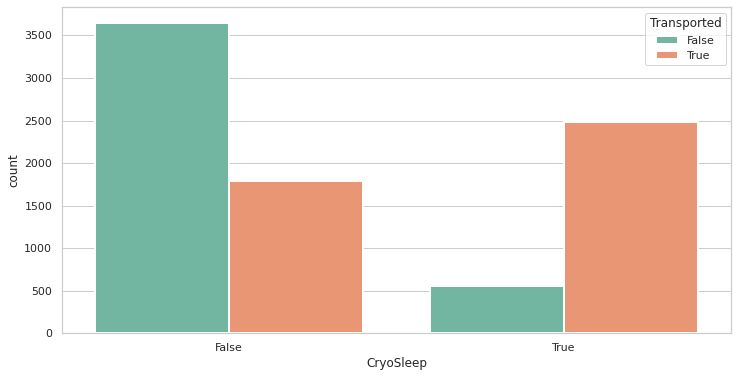

In [14]:
plt.subplots(figsize = (12,6))
ax = sns.countplot(x = "CryoSleep", 
                   hue="Transported",
                   data = data,
                   palette='Set2',
                   linewidth=2)

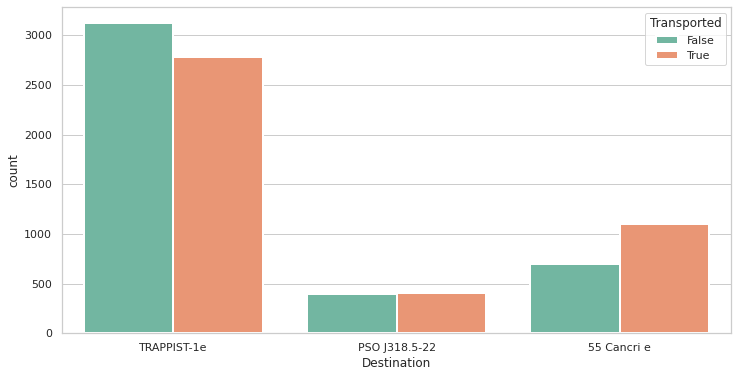

In [15]:
plt.subplots(figsize = (12,6))
ax = sns.countplot(x = "Destination", 
                   hue="Transported",
                   data = data,
                   palette='Set2',
                   linewidth=2)

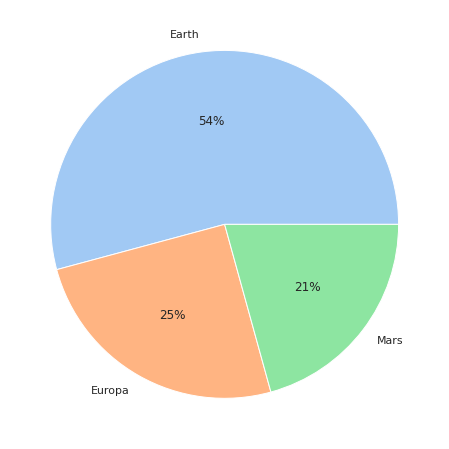

In [25]:
#define Seaborn color palette to use
colors = sns.color_palette('pastel')[ 0:5 ]

#create pie chart
plt.pie(data.HomePlanet.value_counts(), labels = data.HomePlanet.value_counts().index, colors = colors, autopct='%.0f%%')
plt.show()

Диспропорция в Transported завязана на CryoSleep и с диспропрцией от к-ва HomePlanet

# Заполнение данных
***

In [35]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV

## Сервисы

In [194]:
services = ['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']
for serv in services:
    data[serv] = data[serv].fillna(data[serv].median())

## Возраст и имя

заполнем

Заполнение пропусков для признака 'Возраст'

In [128]:
#age_avg = data.Age.mean()
#age_std = data.Age.std()
#age_null_count = data.Age.isnull().sum()
#age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
#data.loc[np.isnan(data.Age), 'Age'] = age_null_random_list
#data.Age = data.Age.astype(int)

In [195]:
data.Age.fillna(data.Age.mean(), inplace=True)
#data.Age = data.Age.astype(int)
data.Name.fillna('No_name', inplace=True)

Сгруппируем возраст

In [196]:
age_gr = ['Very_small','Small','Small_midl','Midl', 'High_midl', 'Old', 'High_old']
results, levels = pd.qcut(data.Age,
                            q=7,
                            labels=age_gr,
                    precision=0,
                            retbins=True)

data['level_age'] = pd.cut(data.Age, bins=levels, labels=age_gr)
data['level_age'].value_counts()

Small         1359
High_midl     1259
High_old      1240
Very_small    1209
Midl          1203
Small_midl    1150
Old           1095
Name: level_age, dtype: int64

Были с 0 возрастом, видимо инкубатор

In [197]:
data['level_age'][data.Age == 0] = 'Very_small'

In [198]:
data.isna().sum()

PassengerId       0
Age               0
RoomService       0
FoodCourt         0
ShoppingMall      0
Spa               0
VRDeck            0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
VIP             203
Name              0
Transported       0
level_age         0
dtype: int64

## Категориальные  с SimpleImputer

In [199]:
frquent_imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
frquent_imputer.fit(data[cat_cols])
data[cat_cols] = frquent_imputer.transform(data[cat_cols])

In [200]:
data.isna().sum()

PassengerId     0
Age             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
HomePlanet      0
CryoSleep       0
Cabin           0
Destination     0
VIP             0
Name            0
Transported     0
level_age       0
dtype: int64

# Доработаем другие данные данных
***

In [201]:
# выделим данные по кабине
data[['deck','num', 'side']] = data['Cabin'].str.split('/', expand=True)

Сделаем черту Группа

In [202]:
# в PassengerId есть намек на группы, которые отображени и в фамилиях
data['pass_id_main']= data['PassengerId'].str.split('_', expand=True)[0]

In [203]:
group_id = data['pass_id_main'].value_counts()

data['Group'] = data['pass_id_main'].apply(lambda x: group_id[x])
#data['Group'] = data['Group'].astype('category')

In [204]:
data.isna().sum()

PassengerId     0
Age             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
HomePlanet      0
CryoSleep       0
Cabin           0
Destination     0
VIP             0
Name            0
Transported     0
level_age       0
deck            0
num             0
side            0
pass_id_main    0
Group           0
dtype: int64

# Удаление и перевод в метки
***

In [205]:
data.drop(['Name', 'Age','pass_id_main', 'Cabin','num'], axis=1, inplace=True)

In [206]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   PassengerId   8693 non-null   object  
 1   RoomService   8693 non-null   float64 
 2   FoodCourt     8693 non-null   float64 
 3   ShoppingMall  8693 non-null   float64 
 4   Spa           8693 non-null   float64 
 5   VRDeck        8693 non-null   float64 
 6   HomePlanet    8693 non-null   object  
 7   CryoSleep     8693 non-null   object  
 8   Destination   8693 non-null   object  
 9   VIP           8693 non-null   object  
 10  Transported   8693 non-null   bool    
 11  level_age     8693 non-null   category
 12  deck          8693 non-null   object  
 13  side          8693 non-null   object  
 14  Group         8693 non-null   int64   
dtypes: bool(1), category(1), float64(5), int64(1), object(7)
memory usage: 900.3+ KB


In [207]:
# Числовые данные
num_cols = list(data.select_dtypes(include=['float64']).dtypes.index)

# категориальные данные
cat_cols = list(data.select_dtypes(include=['object']).dtypes.index) + list(data.select_dtypes(include=['category']).dtypes.index)# + list(data.select_dtypes(include=['int64']).dtypes.index)
cat_cols.remove('PassengerId')

# 
other = ['PassengerId']

# целевые данные
target_col = ['Transported']  # Выживание


# новый порядок
cols = other +  num_cols + cat_cols + target_col

data = data[cols]

In [208]:
data.head(20).style.applymap(coloring).highlight_null(null_color='yellow')

,PassengerId,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,HomePlanet,CryoSleep,Destination,VIP,deck,side,level_age,Transported
0,0001_01,0.000000,0.000000,0.000000,0.000000,0.000000,Europa,False,TRAPPIST-1e,False,B,P,Old,False
1,0002_01,109.000000,9.000000,25.000000,549.000000,44.000000,Earth,False,TRAPPIST-1e,False,F,S,Small_midl,True
2,0003_01,43.000000,3576.000000,0.000000,6715.000000,49.000000,Europa,False,TRAPPIST-1e,True,A,S,High_old,False
3,0003_02,0.000000,1283.000000,371.000000,3329.000000,193.000000,Europa,False,TRAPPIST-1e,False,A,S,High_midl,False
4,0004_01,303.000000,70.000000,151.000000,565.000000,2.000000,Earth,False,TRAPPIST-1e,False,F,S,Very_small,True
5,0005_01,0.000000,483.000000,0.000000,291.000000,0.000000,Earth,False,PSO J318.5-22,False,F,P,Old,True
6,0006_01,42.000000,1539.000000,3.000000,0.000000,0.000000,Earth,False,TRAPPIST-1e,False,F,S,Midl,True
7,0006_02,0.000000,0.000000,0.000000,0.000000,0.000000,Earth,True,TRAPPIST-1e,False,G,S,Midl,True
8,0007_01,0.000000,785.000000,17.000000,216.000000,0.000000,Earth,False,TRAPPIST-1e,False,F,S,High_midl,True
9,0008_01,0.000000,0.000000,0.000000,0.000000,0.000000,Europa,True,55 Cancri e,False,B,P,Very_small,True


### c LabelEncoder()

In [209]:
data_4train = data[num_cols + cat_cols + target_col].apply(LabelEncoder().fit_transform)
data_4train = data_4train.reset_index(drop=True)
x_data = data_4train[num_cols + cat_cols]
y_data = data_4train[target_col]

# Подготовка данных к обучению
***

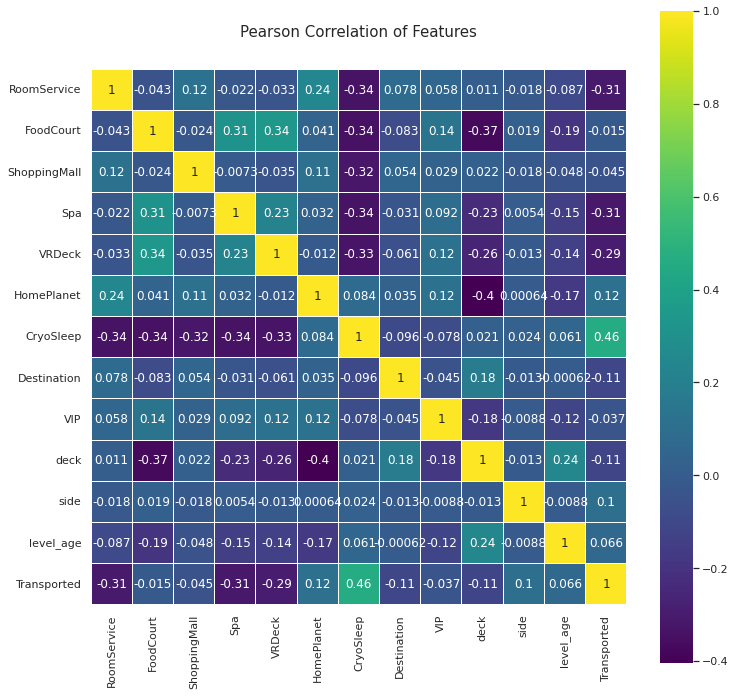

In [210]:
colormap = plt.cm.viridis
plt.figure(figsize=(12,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(data_4train.astype(float).corr(),linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True);

In [211]:
x_data

,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,HomePlanet,CryoSleep,Destination,VIP,deck,side,level_age
0,0,0,0,0,0,1,0,2,0,1,0,3
1,109,9,25,456,44,0,0,2,0,5,1,5
2,43,1206,0,1273,49,1,0,2,1,0,1,1
3,0,806,332,1132,187,1,0,2,0,0,1,0
4,277,69,149,470,2,0,0,2,0,5,1,6
...,...,...,...,...,...,...,...,...,...,...,...,...
8688,0,1389,0,932,74,1,0,0,1,0,0,3
8689,0,0,0,0,0,0,1,1,0,6,1,4
8690,0,0,972,1,0,0,0,2,0,6,1,2
8691,0,739,0,321,1113,1,0,0,0,4,1,0


In [212]:
y_data

,Transported
0,0
1,1
2,0
3,0
4,1
...,...
8688,0
8689,0
8690,1
8691,0


In [241]:
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

###учтем вес классов

In [246]:
class_weights = compute_class_weight('balanced', classes = np.unique(y_data), y = y_data.Transported )
d_class_weights = dict(enumerate(class_weights))
d_class_weights

{0: 1.0073001158748551, 1: 0.9928049337597076}

Хотя дисбаланс тут не критичен

In [213]:
# Разделяем данные
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size = .2,  random_state=8,  stratify=y_data)

# Обучение моделей
***


In [ ]:
from sklearn.metrics import (RocCurveDisplay, confusion_matrix, accuracy_score,
                             classification_report, precision_recall_curve)
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, roc_curve, auc,
                             classification_report)

def est_model(model,
              #X_train, y_train, 
              X_test, y_test,
              #model_params=None
              ):
    #if model_params is None:
        #model_params = dict()
    #print(model.__name__)
    #pipeline = make_pipeline(StandardScaler(), model(**model_params))
    #model.fit(X_train, y_train)

    # Для проверки данных внутри функции
    #sc = StandardScaler()
    #x_train_sc = sc.fit_transform(X_train)
    #x_test_sc = sc.transform(X_test)

    y_pred = model.predict(X_test)
    print('Accuracy:', accuracy_score(y_test, y_pred))
    print('Precision:', precision_score(y_test, y_pred))
    print('Recall:', recall_score(y_test, y_pred))
    print('F1 score:', f1_score(y_test, y_pred))

    fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
    plt.plot(fpr, tpr, color="darkorange", label=f"ROC curve (area = {auc(fpr, tpr):0.3f})")
    plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
    plt.legend()

    print()
    print(classification_report(y_test, y_pred, labels= np.unique(y_test)))
    print(confusion_matrix(y_pred, y_test))

    #for sklearn.__version__ of 1.0 and above
    display = RocCurveDisplay.from_estimator(model, X_test, y_test)
    display.plot()
    plt.show()
    #return model

## c  KFold

In [60]:
from sklearn.model_selection import KFold
from sklearn import tree

In [260]:
## Зададим 10 бачей для функции кросс-валидации
cv = KFold(n_splits=10)     

## Итоговый список с точностью классификации для каждой итерации
accuracies = list()

## Задание диапазона глубин дерева
max_attributes = len(list(x_train))
depth_range = range(1, max_attributes + 1)

## Перебор всех значений max_depth /  Обучение модели для каждого фолда / Расчет точности классификации / Расчет среднего значения точности по всем фолдам
for depth in depth_range:
    fold_accuracy = []
    tree_model = tree.DecisionTreeClassifier(max_depth = depth,  class_weight= d_class_weights)
    for train_fold, valid_fold in cv.split(x_train):
        f_train = x_train.iloc[train_fold] 
        f_valid = x_train.iloc[valid_fold] 

        model = tree_model.fit(X = f_train, 
                               y = y_train.iloc[train_fold]) 
        valid_acc = model.score(X = f_valid, 
                                y = y_train.iloc[valid_fold])
        fold_accuracy.append(valid_acc)

    avg = sum(fold_accuracy)/len(fold_accuracy)
    accuracies.append(avg)
    
df = pd.DataFrame({"Max Depth": depth_range, "Average Accuracy": accuracies})
df = df[["Max Depth", "Average Accuracy"]]
print(df.to_string(index=False))

 Max Depth  Average Accuracy
         1          0.717861
         2          0.717861
         3          0.717717
         4          0.763595
         5          0.768918
         6          0.779411
         7          0.781854
         8          0.783724
         9          0.775239
        10          0.771788
        11          0.766612
        12          0.767043


Максимальная глубина дерева оптимальная 8

Accuracy: 0.7786083956296722
Precision: 0.7507660878447395
Recall: 0.839041095890411
F1 score: 0.7924528301886792

              precision    recall  f1-score   support

           0       0.81      0.72      0.76       863
           1       0.75      0.84      0.79       876

    accuracy                           0.78      1739
   macro avg       0.78      0.78      0.78      1739
weighted avg       0.78      0.78      0.78      1739

[[619 141]
 [244 735]]


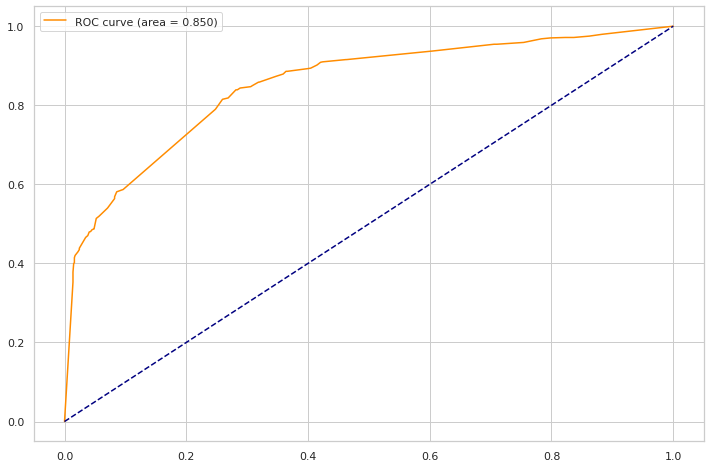

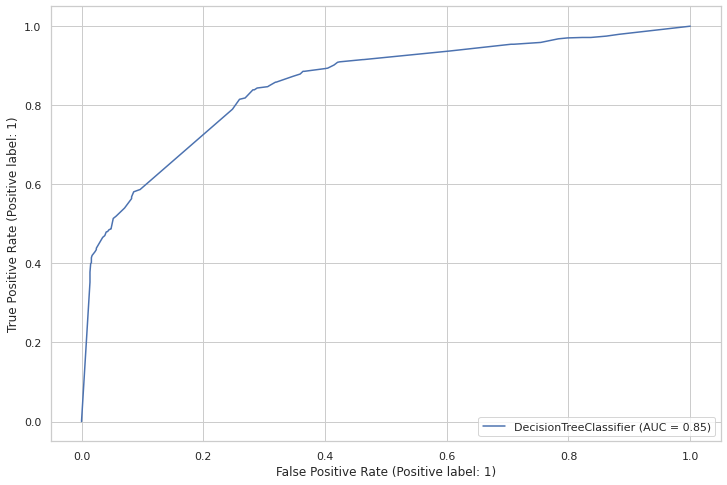

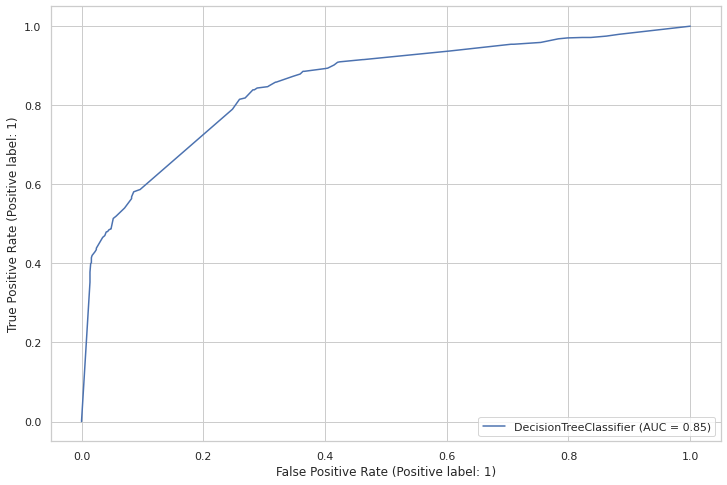

In [262]:
tree_model = tree.DecisionTreeClassifier(max_depth = 8,
                                        class_weight= d_class_weights
                                         )
model = tree_model.fit(X = x_train, 
                               y = y_train) 
valid_acc = model.score(X = x_test, 
                                y = y_test)

est_model(model, x_test, y_test)

### Плучили 0.78
это по обычной точности , ошибка у нас больше в определении погибших, нужно еще изучать, что понижает точность

В результате проб выяснилось, Age лучше оставить float и вновь сделанный парамметр Group убрать, так как оня понижал точность

## c GridSearchCV
https://medium.com/@mohtedibf/indepth-parameter-tuning-for-decision-tree-6753118a03c3

https://www.kaggle.com/code/gauravduttakiit/hyperparameter-tuning-in-decision-trees

In [287]:
def dtree_grid_search(X,y,nfolds):
    #create a dictionary of all values we want to test
    param_grid = { 'criterion':['gini','entropy', 'log_loss'],
                  'max_depth': np.arange(3,  len(list(X))),
                  #'min_samples_leaf' : np.linspace(0.1, 0.5, 5, endpoint=True),
                  'max_features': ['auto', 'sqrt', 'log2'],
                  'ccp_alpha': [0.1, .01, .001],
                  }
    # decision tree model
    dtree_model=tree.DecisionTreeClassifier(class_weight= d_class_weights)
    #use gridsearch to test all values
    dtree_gscv = GridSearchCV(dtree_model, param_grid, cv=nfolds)
    #fit model to data
    dtree_gscv.fit(X, y)
    return dtree_gscv.best_params_

этот перебор уже долгий

In [288]:
best_atributs = dtree_grid_search(x_train, y_train, 12)
best_atributs

{'ccp_alpha': 0.001,
 'criterion': 'entropy',
 'max_depth': 10,
 'max_features': 'auto'}

Accuracy: 0.777458309373203
Precision: 0.7592788971367974
Recall: 0.817351598173516
F1 score: 0.7872457394172623

              precision    recall  f1-score   support

           0       0.80      0.74      0.77       863
           1       0.76      0.82      0.79       876

    accuracy                           0.78      1739
   macro avg       0.78      0.78      0.78      1739
weighted avg       0.78      0.78      0.78      1739

[[636 160]
 [227 716]]


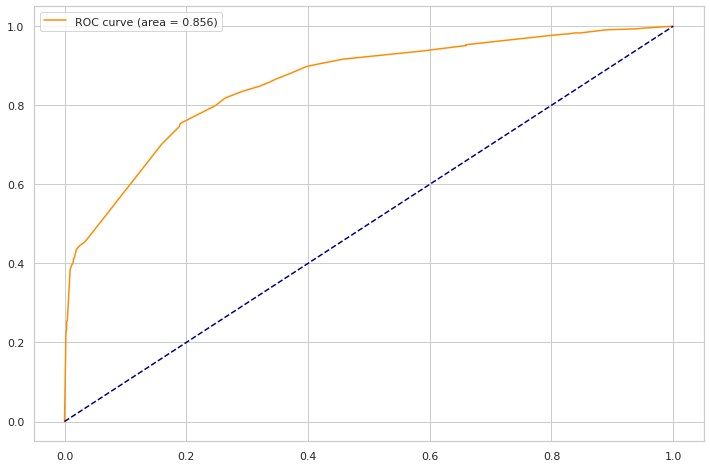

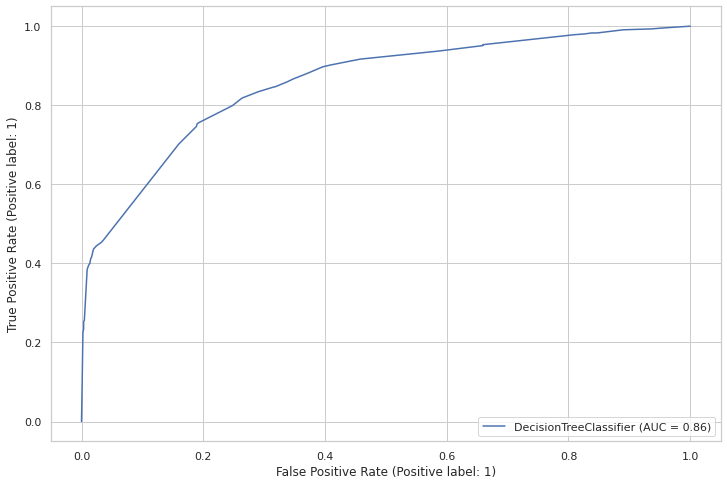

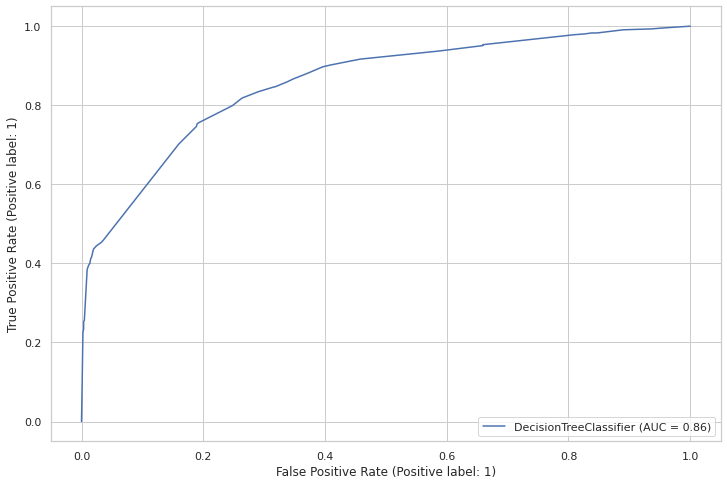

In [292]:
tree_model = tree.DecisionTreeClassifier(ccp_alpha=best_atributs['ccp_alpha'],
                                         criterion=best_atributs['criterion'],
                                         max_depth = best_atributs['max_depth'],
                                         max_features = best_atributs['max_features'],
                                         class_weight= d_class_weights
                                          )
model = tree_model.fit(X = x_train, 
                               y = y_train) 
valid_acc = model.score(X = x_test, 
                                y = y_test)

est_model(model, x_test, y_test)

### Получили 0.78

Точность повысить не удалось выше